In [1]:

# Sys imports
import json
import os
import sys
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "jax"

# Training API
import keras as keras
from keras import layers
import keras_nlp

# Data manipulation and exploration
import numpy as np
from scipy.stats import shapiro, kurtosis

# Data visualization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import jax.numpy as jnp

# MLOps API
# import mlflow
# mlflow.set_tracking_uri('http://localhost:5000')


2024-04-15 03:57:44.465820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 03:57:44.465856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 03:57:44.466873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 03:57:45.090694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# EDA

## Data loading
There are 72M titles and views in the data used.

In [2]:
# DATA LOADER 
def parse_jsonl_optimized(filepath, num_lines_to_import=None):
    titles = []
    view_counts = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for i, line in enumerate(tqdm(file, desc="Processing")):
            # Check if the specified number of lines has been reached (if specified)
            if (num_lines_to_import is not None and i >= num_lines_to_import):
                break
            # Parse the current line
            data = json.loads(line)
            # Extract and store the title and view count
            titles.append(data['title'])
            view_counts.append(data['view_count'])
    return titles, view_counts

# Example usage: Import only the first 1000 lines from the file
file_path = '/mnt/datassd/train_data.jsonl'
num_lines_to_import = 1000000  # You can adjust this number as needed
titles, view_counts = parse_jsonl_optimized(file_path, num_lines_to_import)

Processing: 1000000it [00:01, 594235.71it/s]


## Create $Log_{10}(Data)$ and create tokenizer

When views are analyzed on their own, the MSE loss function does not make a lot of sense, there is a lot of variation in the data.

What's why we take $log_{10}$ to get the order of magnitude of the views ($10^x$).

In [3]:
log_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))

from transformers import BertTokenizer, BertModel
from concurrent.futures import ThreadPoolExecutor

# Load BERT tokanizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

/tmp/ipykernel_15673/1308870409.py:1: RuntimeWarning: divide by zero encountered in log10
  log_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))


Encoding all 70M datapoints takes ~45mins

In [4]:
""" SINGLE THREADED  """
encoded_inputs = [tokenizer.encode(title, add_special_tokens=True) for title in tqdm(titles, total=len(titles), desc="Encoding")]

Encoding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:51<00:00, 8982.44it/s]


In [6]:
# save the encoded_inputs to disk
np.save('encoded_inputs1m.npy', encoded_inputs)
# save view counts to ensure that the order is preserved
np.save('view_counts1m.npy', view_counts)

/home/jay/.local/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#""" SOMEWHAT MULTITHREADED """
#def encode_title(title):
#    return tokenizer.encode(title, add_special_tokens=True)
#with ThreadPoolExecutor() as executor:
#    encoded_inputs = list(tqdm(executor.map(encode_title, titles), total=len(titles), desc="Encoding"))

In the context of title engagement, UPPER CASED titles correlate with engagement, it is important to use a CASED tokenizer.

In [10]:
# Testing cased inputs in tokenization
titulos_raros = [r'IS THIS TOKEN Cased?']
print(tokenizer.tokenize(titulos_raros[0]))
tokenizer.encode(titulos_raros[0], add_special_tokens=True)


['IS', 'T', '##H', '##IS', 'TO', '##KE', '##N', 'Case', '##d', '?']


[101, 19432, 157, 3048, 6258, 16972, 22441, 2249, 9060, 1181, 136, 102]

In [11]:
bert = BertModel.from_pretrained('bert-base-cased')

## Data Normalization tests

First, let's see the distribution of view counts

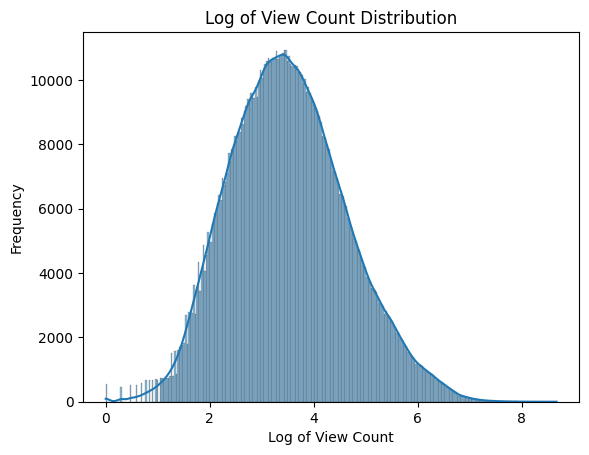

In [12]:
# See Y view count distribution
sns.histplot(log_view_count, kde=True)
plt.title("Log of View Count Distribution")
plt.xlabel("Log of View Count")
plt.ylabel("Frequency")
plt.show()

In [13]:
shapiro_test_stat, shapiro_p_value = shapiro(log_view_count)
kurtosis_value = kurtosis(log_view_count, fisher=True)

shapiro_test_stat, shapiro_p_value, kurtosis_value

/home/jay/.local/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9953887462615967, 0.0, -0.09748136762154314)

In [14]:
sample_titles_i = 500000
print(view_counts[sample_titles_i:sample_titles_i+5])
print(log_view_count[sample_titles_i:sample_titles_i+5])
titles[sample_titles_i:sample_titles_i+5]


[8684, 21008, 4783, 2393, 4754]
[3.93871981 4.32238471 3.67970038 3.3789427  3.67705918]


['Fortnite ITEM SHOP (NEW ROBOT SKIN) Fortnite Battle Royale',
 'Fortnite Scanline Wrap Gameplay / Showcase! (Fortnite Battle Royale)',
 'Fortnite ITEM SHOP (NEW BANNER SKINS) Fortnite Battle Royale',
 'Fortnite DARE Skin Gameplay!',
 'Fortnite Epic And Legendary Tactical Shotgun!']

As you can see, some titles that look very similar have wildly different view counts.
So, we're going to define some "activation function" to rescale the rewards of the model.
This activation function needs to be centered at 4. Because anything with views<1000 is considered not good.
Maybe the "centerded-ness" of the function can serve as a hyperparameter.

Function chosen was ReLU modified to fit criteria Relu(highest_view) = 255
so that the highest view matches exactly the highest output value of a neuron of 255

to get the slope of the relu to match this criteria we can solve for slope on the following equation.

$ReLU(x) = slope \cdot (x - center) \cdot (x>center) + \epsilon$

which when $ReLU(highest\_value) = 255$ gives us a slope of 

$slope = \frac{255-\epsilon}{highest\_value - center}$

In [ ]:
def activation(x, center, epsilon, slope):
    return  slope*(x-center) * (x>center) + epsilon    

# Let's graph it to see what it looks like
x = np.linspace(0, 10, 100)
center = 4
epsilon = 0.1

# Get highest view
highest_view = max(log_view_count)
# See markdown above
slope = (255-epsilon)/(highest_view-center)

print(highest_view)

plt.plot(x, activation(x, center, epsilon, slope))
plt.axvline(x=center, color='r', linestyle='--')
plt.text(center, 2, 'center', verticalalignment='bottom')
plt.axhline(y=epsilon, color='r', linestyle='--')
# Plot point (highest_view, 255)
plt.plot(highest_view, activation(highest_view,center,epsilon,slope), 'ro')
plt.text(highest_view, activation(highest_view,center,epsilon,slope), '(highest view, 255)', verticalalignment='bottom')
plt.text(0, epsilon, 'epsilon', verticalalignment='bottom')
plt.title("ReLU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

In [ ]:
ac_views = activation(log_view_count, center=center, epsilon=epsilon, slope = slope)
sorted_ac_views = np.sort(ac_views)
sorted_ac_views[:5], sorted_ac_views[-5:]

Now let's see the ditribution of lenghts of titles.

We need to have a cutoff at a certain token lenght. So let's visualize when it would be appropriate to cut titles off.

In [ ]:
sns.histplot([len(encoded_input) for encoded_input in encoded_inputs], bins=50)
plt.title("Histogram of tokenized title lengths")
plt.xlabel("Length of tokenized title")
plt.ylabel("Number of titles")
plt.show()

Probably at 40 tokens, the cutoff would preserve most of the information. (Remember YouTube titles have a 100 char limit)

In [ ]:
max_length = 40  # Ensure your data is adjusted accordingly

padded_inputs = pad_sequences(encoded_inputs, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# Just making sure, all inputs are the same length of 40 
sns.histplot([len(padded_input) for padded_input in padded_inputs], bins=50)
plt.title("Histogram of padded title lengths")
plt.xlabel("Length of padded title")
plt.ylabel("Number of titles")
plt.show()

Some samples to see the PADs

In [ ]:
sample = [tokenizer.decode(padded_input) for padded_input in padded_inputs[90:100]]
sample

In [ ]:
X_t = jnp.array(padded_inputs)
Y_t = jnp.array(ac_views)

vocab_size = 30522  # Adjusted to match BERT's vocabulary size for bert-base-cased
embedding_dim = 768  # Standard BERT-base embedding dimension
transformer_encoder_layers = 1  # Increase this for a larger model
num_heads = 12  # Increase this for a larger model
intermediate_dim = 768*2  # Dimensionality of the encoder layers and the pooler layer
dropout_rate = 0.1  # Dropout rate for regularization


In [ ]:
# Input layer
inputs = keras.Input(shape=(max_length,), dtype='int32')

# Embedding layer
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size, 
    sequence_length=max_length, 
    embedding_dim=embedding_dim,
)

x = embedding_layer(inputs)

# Without embedding layer

# x = inputs

# Transformer blocks
for _ in range(transformer_encoder_layers):
    encoder = keras_nlp.layers.TransformerEncoder(
        num_heads=num_heads,
        intermediate_dim=intermediate_dim,
        activation='relu',
        dropout=dropout_rate,
    )
    x = encoder(x)

# Pooling and output layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(embedding_dim, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)  # Use linear activation for regression

# Model compilation
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Display the model's architecture
model.summary()

In [ ]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps


with mlflow.start_run() as run:
    model.fit(X_t, Y_t, batch_size=64, epochs=5, validation_split=0.2, callbacks= [MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)])
mlflow.end_run()

# Evaluation

In [ ]:
# Load the eval dataset
eval_file_path = '/mnt/datassd/train_data.jsonl'
titles_eval, view_counts_eval = parse_jsonl_optimized(eval_file_path, num_lines_to_import*0.01)
encoded_evals = [tokenizer.encode(title_ev, add_special_tokens=True) for title_ev in tqdm(titles_eval, total=len(titles_eval), desc="Encoding")]
padded_evals = pad_sequences(encoded_evals, maxlen=max_length, padding='post', truncating='post')
view_evals = np.where(np.log10(view_counts_eval) == -np.inf, 0, np.log10(view_counts_eval))
ac_views_evals = activation(view_evals, center=center, epsilon=epsilon, slope=slope)

In [ ]:
Y_e = jnp.array(ac_views_evals)
X_e = jnp.array(padded_evals)

In [ ]:
Y_pred = model.predict(X_e)

# Make scatter of predicted vs actual
plt.scatter(Y_e, Y_pred)
# Make a line
plt.plot([0, 10], [0, 10], color='red')
plt.title("Predicted vs Actual Score")
plt.xlabel("Actual Score View Count")
plt.ylabel("Predicted Score View Count")
plt.show()

In [ ]:
Y_pred = Y_pred.flatten()
Y_pred

In [ ]:
# Arange titles by highest predicted view count
sorted_titles = [title for _, title in sorted(zip(Y_pred, titles_eval), reverse=True)]
sorted_titles[:50], sorted_titles[-50:]